In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn import mixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

random_seed=5000

In [331]:
data = pd.read_csv('wineQualityReds.csv')

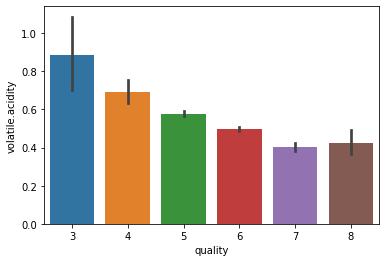

In [332]:
sns.barplot(x = 'quality', y = 'volatile.acidity', data = data)

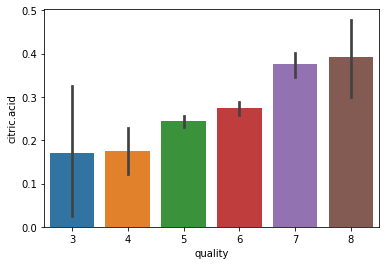

In [333]:
sns.barplot(x = 'quality', y = 'citric.acid', data = data)

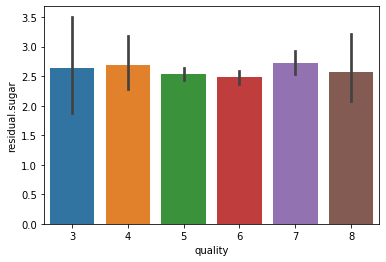

In [334]:
sns.barplot(x = 'quality', y = 'residual.sugar', data = data)

### Binary Classification

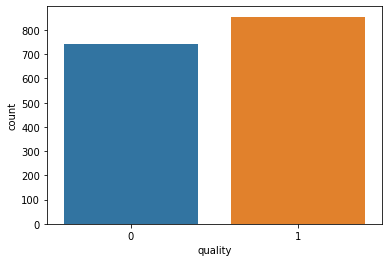

In [335]:
data['quality'] = data.quality.apply(lambda q: 0 if q <= 5 else 1)
y = data['quality']
sns.countplot(y)

In [336]:
data.head()
data.columns

Index(['Unnamed: 0', 'fixed.acidity', 'volatile.acidity', 'citric.acid',
       'residual.sugar', 'chlorides', 'free.sulfur.dioxide',
       'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

In [337]:
data = data.drop('Unnamed: 0', axis=1)

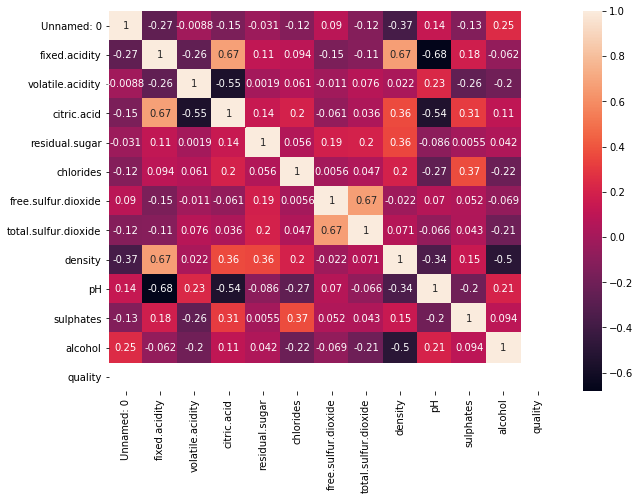

In [402]:
plt.figure(figsize=(10,7))
sns.heatmap(data[data.columns[0:]].corr(), annot=True)

plt.savefig('WQPairplot.png')

In [339]:
x = data.drop('quality', axis=1)
x = StandardScaler().fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(x, y, test_size=0.2, random_state=0)

### Curves

In [340]:
def plot_learning_curve(classifier, x, y, title):
    n = len(y)
    train_size = np.linspace(0.1, 1.0, 20)
    
    _, train_scores, test_scores = learning_curve(classifier, x, y, scoring='accuracy', train_sizes=train_size, cv=5)
    
    plt.figure()
    plt.plot(train_size, np.mean(train_scores, axis=1), 'o-', label="Training Score")
    plt.plot(train_size, np.mean(test_scores, axis=1), 'o-', label="Cross-Validation Score")
    plt.title(title)
    plt.xlabel("Fraction of DataSet")
    plt.ylabel("Classification Score")
    plt.legend(loc="best")
    plt.grid(axis='both')
    
    # plt.savefig('SVMLineartuned.png')
    
def plot_validation_curve(classifier, x, y, p, p_range, cv, title, attribute):
    train, test = validation_curve(classifier, x, y, param_name=p, param_range=p_range, cv=cv)
    
    title = 'Validation Curve for ' + title
    
    plt.figure(figsize=(7,5))
    plt.plot(p_range, np.mean(train, axis=1), label='Training Score')
    plt.plot(p_range, np.mean(test, axis=1), label='CV Score')
    plt.title(title)
    plt.xlabel(attribute)
    plt.ylabel('Classification Score')
    plt.legend(loc='best')
    plt.grid()
    
    # plt.savefig('CancerLinearCMCC.png')

# Experiment 1

#### K Means Clustering

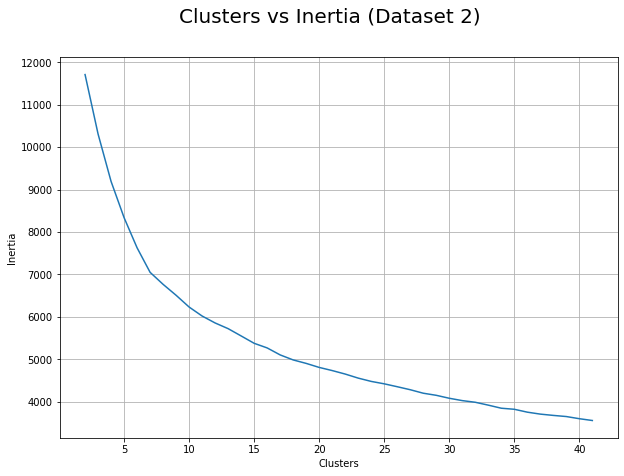

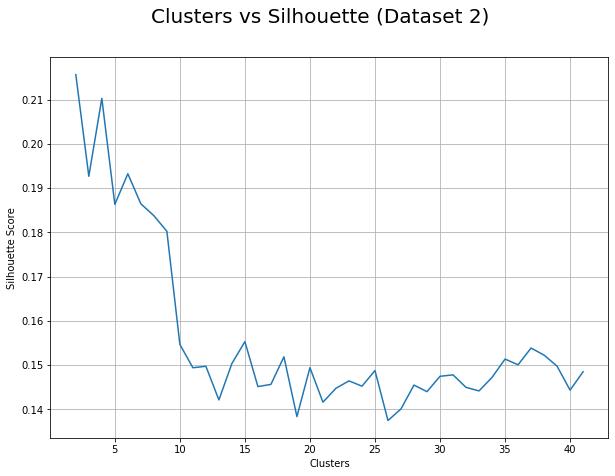

In [341]:
clusters = 2 + np.arange(40)

scores = []
init_inertia = []
init_silhouette = []
i=0

for cluster in clusters:
    classifier = KMeans(n_clusters=cluster, max_iter=1000, random_state=random_seed)
    classifier = classifier.fit(X_real_train, y_real_train)
    init_inertia.append(classifier.inertia_)
    init_silhouette.append(silhouette_score(X_real_train, classifier.labels_))
    
    y_pred = classifier.predict(X_real_test)
    accuracy = metrics.accuracy_score(y_pred, y_real_test)
    
    scores.append(accuracy)
    i += 1
    
    
plt.figure(figsize=(10, 7))
plt.suptitle("Clusters vs Inertia (Dataset 2)", fontsize=20)
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.plot(clusters, init_inertia)
plt.grid()
plt.savefig('WQClusteringInertia.png')
plt.show()

plt.figure(figsize=(10, 7))
plt.suptitle("Clusters vs Silhouette (Dataset 2)", fontsize=20)
plt.ylabel("Silhouette Score")
plt.xlabel("Clusters")
plt.plot(clusters, init_silhouette)
plt.grid()
plt.savefig('WQClusteringSilhouette.png')
plt.show()

#### Using best Elbow and Slihouette Number of Clusters

In [343]:
elbow = 8
silhouette = 2

print("===========================")
print("Elbow Method: ")
classifier = KMeans(n_clusters=elbow, max_iter=1000, random_state=random_seed)
classifier = classifier.fit(X_real_train, y_real_train)
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Accuracy: ", accuracy)

print("===========================")
print("Silhouette Method: ")
classifier_2 = KMeans(n_clusters=silhouette, max_iter=1000, random_state=random_seed)
classifier_2.fit(X_real_train, y_real_train)
y_pred = classifier_2.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Accuracy: ", accuracy)

print("===========================")
print("END")

Elbow Method: 
Accuracy:  0.2375
Silhouette Method: 
Accuracy:  0.428125
END


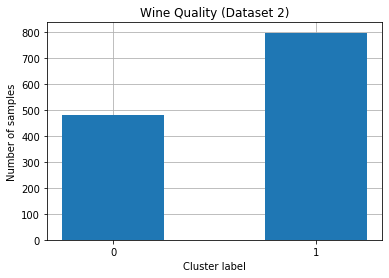

In [346]:
plt.figure()
plt.hist(classifier_2.labels_, bins=np.arange(0, silhouette + 1) - 0.5, rwidth=0.5, zorder=2)
plt.xticks(np.arange(0, silhouette))
plt.xlabel('Cluster label')
plt.ylabel('Number of samples')
plt.title('Wine Quality (Dataset 2)')
plt.grid()
plt.savefig('WQDistribution.png')

### EM

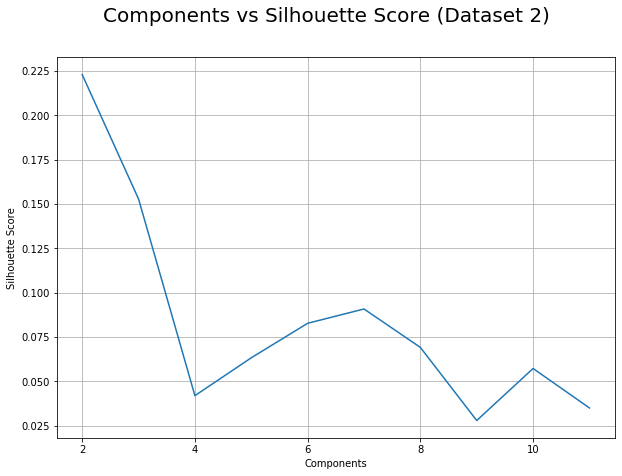

In [272]:
clusters = 2 + np.arange(10)
scores = []
i=0

for cluster in clusters:
    classifier = GaussianMixture(n_components=cluster, max_iter=1000, random_state=random_seed)
    classifier = classifier.fit(X_real_train, y_real_train)
    curr_y = classifier.predict(X_real_test)
    
    scores.append(silhouette_score(X_real_test, curr_y))
    accuracy = metrics.accuracy_score(y_pred, y_real_test)
    
    i += 1


plt.figure(figsize=(10, 7))
plt.suptitle("Components vs Silhouette Score (Dataset 2)", fontsize=20)
plt.ylabel("Silhouette Score")
plt.xlabel("Components")
plt.plot(clusters, scores)
plt.grid()
plt.savefig('WQEMSilhouette.png')
plt.show()

#### BIC Score

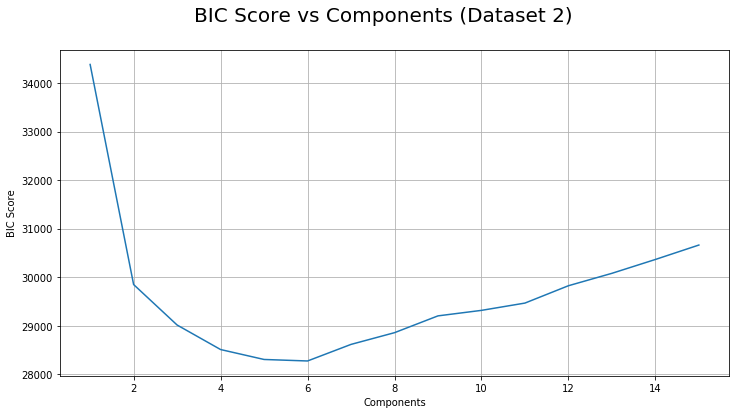

In [273]:
init_bic = []
components = 1 + np.arange(15)

for component in components:
    gmm = GaussianMixture(n_components=component, max_iter=1000, 
                              covariance_type=cv_type, random_state=random_seed)
    gmm.fit(X_real_train, y_real_train)
    init_bic.append(gmm.bic(X_real_train))
        
init_bic = np.array(init_bic)

plt.figure(figsize=(12, 6))
plt.suptitle('BIC Score vs Components (Dataset 2)', fontsize=20)
plt.xlabel('Components')
plt.ylabel('BIC Score')
plt.plot(components, init_bic)
plt.grid()
plt.savefig('WQEMBIC.png')
plt.show()

#### Testing best No. of Components

In [347]:
# Silhouette Score
cluster = 2
classifier = GaussianMixture(n_components=cluster, max_iter=1000, random_state=random_seed)
classifier = classifier.fit(X_real_train, y_real_train)
curr_y = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Accuracy: ", accuracy)

# BIC Score
cluster = 5
classifier = GaussianMixture(n_components=cluster, max_iter=1000, random_state=random_seed)
classifier = classifier.fit(X_real_train, y_real_train)
curr_y = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Accuracy: ", accuracy)

Accuracy:  0.428125
Accuracy:  0.428125


# Dimensionality Reduction

### PCA

In [350]:
data = pd.read_csv('wineQualityReds.csv')
data_= data.drop('Unnamed: 0', axis=1)
data['quality'] = data.quality.apply(lambda q: 0 if q <= 5 else 1)
y = data['quality']
x = data.drop('quality', axis=1)
x = StandardScaler().fit_transform(x)

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(x, y, test_size=0.2, random_state=0)

#### K Means

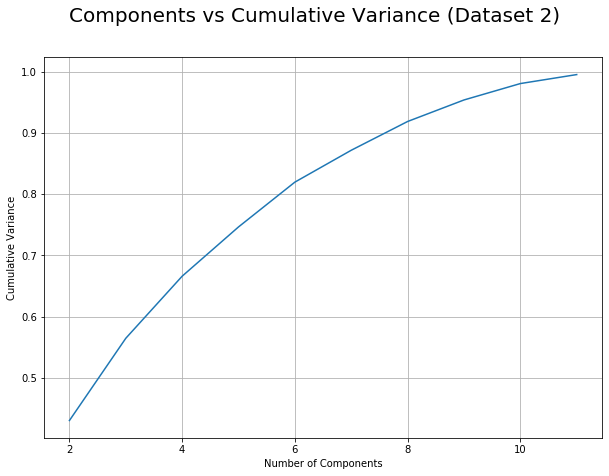

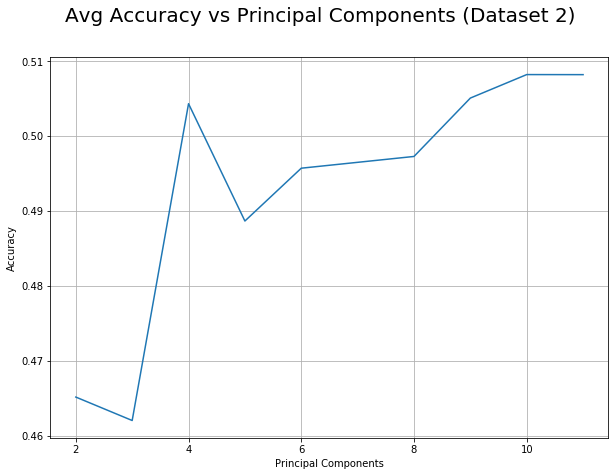

In [352]:
components = 2 + np.arange(10)
var = []
fin_acc = []
t = []

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)

for component in components:
#     print("==============================")
#     print("Number of components: ", component)
    
    pca = PCA(n_components = component, random_state=random_seed)
    principalComponents = pca.fit_transform(x)
    var.append(sum(pca.explained_variance_ratio_))
    
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        principalComponents, y, test_size=0.2, random_state=random_seed)
    
    classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)
    
    acc = []
    
    for train_index, test_index in kf.split(X_real_train):
        y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
        X_train = X_real_train[[train_index]]
        X_test = X_real_train[[test_index]]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc.append(metrics.accuracy_score(y_pred, y_test))
        i += 1
    
#     print("Average Accuracy: ", sum(acc)/len(acc))
    fin_acc.append(sum(acc)/len(acc))
        
plt.figure(figsize=(10,7))
plt.suptitle('Components vs Cumulative Variance (Dataset 2)', fontsize=20)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.plot(components, var)
plt.grid()
plt.savefig('WQPCAVariance.png')
plt.show()

plt.figure(figsize=(10, 7))
plt.suptitle('Avg Accuracy vs Principal Components (Dataset 2)', fontsize=20)
plt.xlabel('Principal Components')
plt.ylabel('Accuracy')
plt.plot(components, fin_acc)
plt.grid()
# plt.savefig('WQPCAAccuracy.png')
plt.show()

#### Reproducing

In [358]:
var = []
fin_acc = []
t = []

pca = PCA(n_components = 8, random_state=random_seed)
principalComponents = pca.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = KMeans(n_clusters=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.3330669403076172
Testing Accuracy:  0.565625


#### Metrics

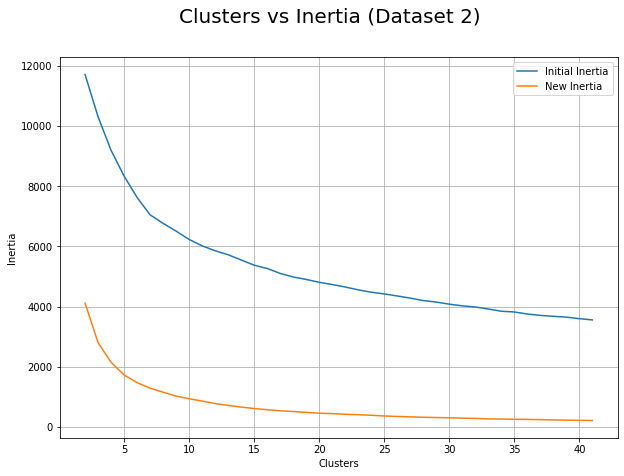

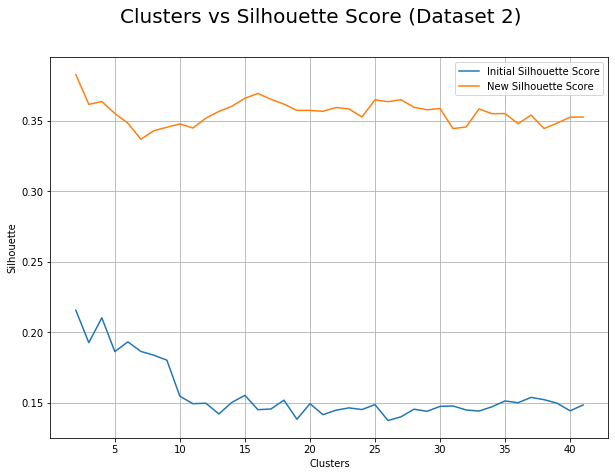

In [360]:
clusters = 2 + np.arange(40)

scores = []
inertia = []
silhouette = []
i=0

pca = PCA(n_components = 2, random_state=random_seed)
principalComponents = pca.fit_transform(x)

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)

for cluster in clusters:
    classifier = KMeans(n_clusters=cluster, max_iter=1000, random_state=random_seed)
    classifier = classifier.fit(X_real_train, y_real_train)
    inertia.append(classifier.inertia_)
    silhouette.append(silhouette_score(X_real_train, classifier.labels_))
    
    y_pred = classifier.predict(X_real_test)
    accuracy = metrics.accuracy_score(y_pred, y_real_test)
    
    scores.append(accuracy)
    i += 1
    
    
plt.figure(figsize=(10, 7))
plt.suptitle("Clusters vs Inertia (Dataset 2)", fontsize=20)
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.plot(clusters, init_inertia, label='Initial Inertia')
plt.plot(clusters, inertia, label='New Inertia')
plt.legend()
plt.grid()
plt.savefig('NewInertia.png')
plt.show()

plt.figure(figsize=(10, 7))
plt.suptitle("Clusters vs Silhouette Score (Dataset 2)", fontsize=20)
plt.xlabel("Clusters")
plt.ylabel("Silhouette")
plt.plot(clusters, init_silhouette, label='Initial Silhouette Score')
plt.plot(clusters, silhouette, label='New Silhouette Score')
plt.grid()
plt.legend()
plt.savefig('NewSilhouette.png')
plt.show()

### EM

Number of components:  2
Average Accuracy:  0.46828125
Number of components:  3
Average Accuracy:  0.4619944852941177
Number of components:  4
Average Accuracy:  0.5027696078431372
Number of components:  5
Average Accuracy:  0.5004044117647058
Number of components:  6
Average Accuracy:  0.4988419117647059
Number of components:  7
Average Accuracy:  0.49963541666666667
Number of components:  8
Average Accuracy:  0.4941482843137255
Number of components:  9
Average Accuracy:  0.49806985294117645
Number of components:  10
Average Accuracy:  0.4957169117647059
Number of components:  11
Average Accuracy:  0.49728553921568625


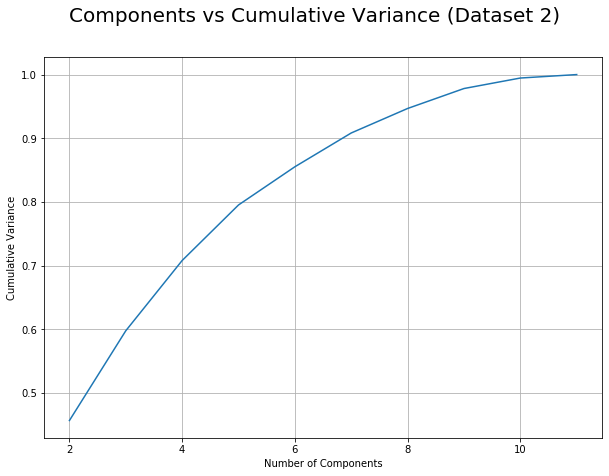

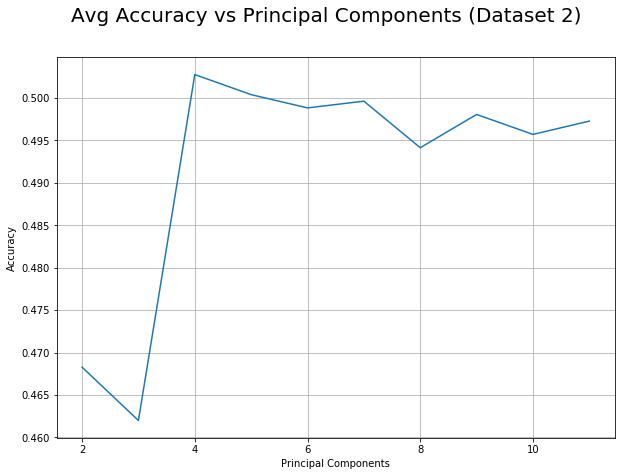

In [278]:
components = 2 + np.arange(10)
var = []
fin_acc = []
t = []

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)

for component in components:
    print("==============================")
    print("Number of components: ", component)
    
    pca = PCA(n_components = component, random_state=random_seed)
    principalComponents = pca.fit_transform(x)
    var.append(sum(pca.explained_variance_ratio_))
    
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        principalComponents, y, test_size=0.2, random_state=random_seed)
    
    classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)
    
    acc = []
    
    for train_index, test_index in kf.split(X_real_train):
        y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
        X_train = X_real_train[[train_index]]
        X_test = X_real_train[[test_index]]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc.append(metrics.accuracy_score(y_pred, y_test))
        i += 1
    
    print("Average Accuracy: ", sum(acc)/len(acc))
    fin_acc.append(sum(acc)/len(acc))
        
plt.figure(figsize=(10,7))
plt.suptitle('Components vs Cumulative Variance (Dataset 2)', fontsize=20)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.plot(components, var)
plt.grid()
# plt.savefig('BCPCA.png')
plt.show()

plt.figure(figsize=(10, 7))
plt.suptitle('Avg Accuracy vs Principal Components (Dataset 2)', fontsize=20)
plt.xlabel('Principal Components')
plt.ylabel('Accuracy')
plt.plot(components, fin_acc)
plt.grid()
plt.show()

#### Reproducing

In [359]:
var = []
fin_acc = []
t = []

pca = PCA(n_components = 8, random_state=random_seed)
principalComponents = pca.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.16578197479248047
Testing Accuracy:  0.453125


#### Metrics

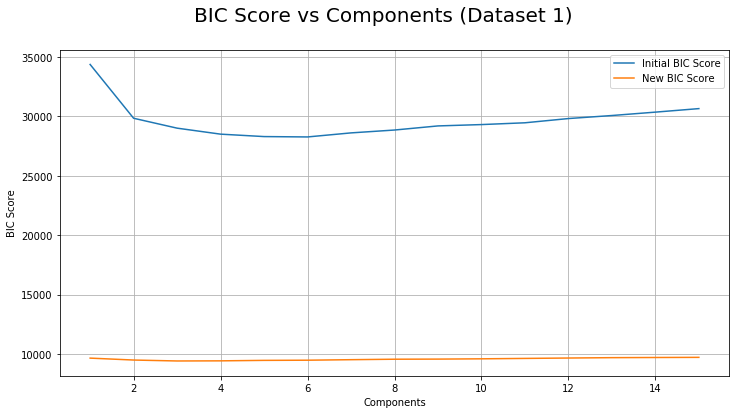

In [280]:
bic = []
components = 1 + np.arange(15)

pca = PCA(n_components = 2, random_state=random_seed)
principalComponents = pca.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)

for component in components:
    gmm = GaussianMixture(n_components=component, max_iter=1000, 
                              covariance_type=cv_type, random_state=random_seed)
    gmm.fit(X_real_train, y_real_train)
    bic.append(gmm.bic(X_real_train))
        
bic = np.array(bic)

plt.figure(figsize=(12, 6))
plt.suptitle('BIC Score vs Components (Dataset 1)', fontsize=20)
plt.xlabel('Components')
plt.ylabel('BIC Score')
plt.plot(components, init_bic, label='Initial BIC Score')
plt.plot(components, bic, label='New BIC Score')
plt.grid()
plt.legend()
# plt.savefig('BCEMBIC.png')
plt.show()


### Neural Network

In [387]:
data = pd.read_csv('wineQualityReds.csv')
data_= data.drop('Unnamed: 0', axis=1)
data['quality'] = data.quality.apply(lambda q: 0 if q <= 5 else 1)
y = data['quality']
x = data.drop('quality', axis=1)
x = StandardScaler().fit_transform(x)

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(x, y, test_size=0.2, random_state=0)

Total Time Taken:  39.373916149139404
Testing Accuracy:  0.759375


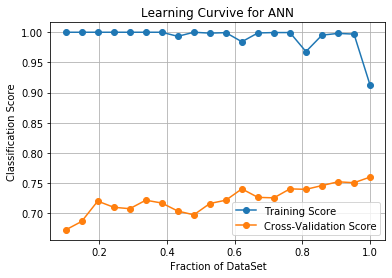

In [389]:
## With regular feature space

pca = PCA(n_components = 2, random_state=random_seed)
principalComponents = pca.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    x, y, test_size=0.2, random_state=0)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")
plt.savefig('WQOriginalNN.png')

Total Time Taken:  1.581474781036377
Testing Accuracy:  0.66875


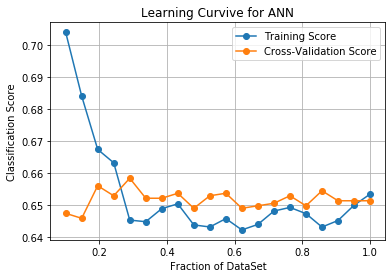

In [390]:
## With K Means feature space

pca = PCA(n_components = 2, random_state=random_seed)
principalComponents = pca.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, alpha=0.0042, 
                           max_iter=5000, hidden_layer_sizes=(9,))

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")
plt.savefig('WQPCANN.png')

#### Hyperparameter Tuning

In [328]:
## Tuning

alpha = np.linspace(0.0001, 0.01, 50)

parameters = [{'alpha': alpha}]


t0 = time.time()
print("Searching:")
classifier = GridSearchCV(MLPClassifier(hidden_layer_sizes=(3,), max_iter=5000), parameters, 'f1')
classifier.fit(X_real_train, y_real_train)
t1 = time.time()
total_time = t1 - t0

print("Total time taken: ", total_time)
print(classifier.best_params_)

Searching:
Total time taken:  134.4357409477234
{'alpha': 0.0071714285714285725}


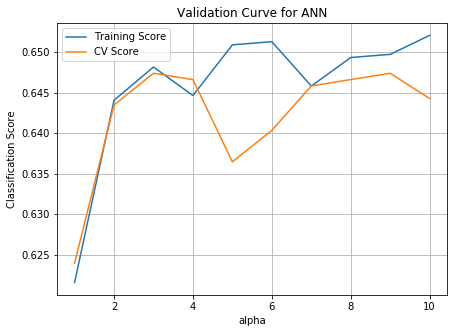

In [326]:
## Validation Curve

parameter = 'hidden_layer_sizes'
parameter_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plot_validation_curve(MLPClassifier(max_iter=5000),
                      X_real_train, y_real_train, 
                      parameter, parameter_range, cv=5, title='ANN', attribute="alpha")

In [321]:
## With EM Feature Space

pca = PCA(n_components = 4, random_state=random_seed)
principalComponents = pca.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    principalComponents, y, test_size=0.2, random_state=0)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  8.384319305419922
Testing Accuracy:  0.721875


# ICA

In [361]:
data['quality'] = data.quality.apply(lambda q: 0 if q <= 5 else 1)
y = data['quality']
x = data.drop('quality', axis=1)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(x, y, test_size=0.2, random_state=0)

### K Means

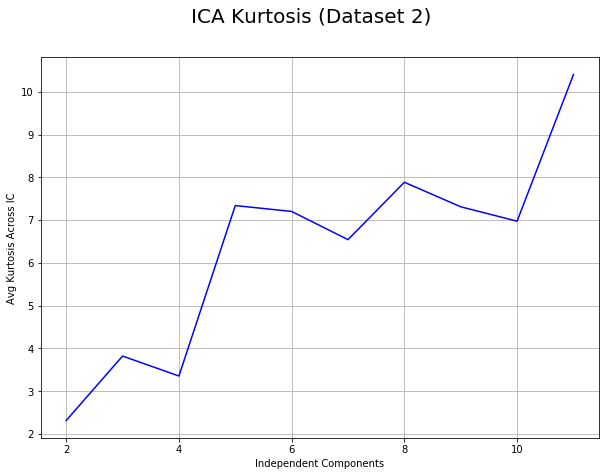

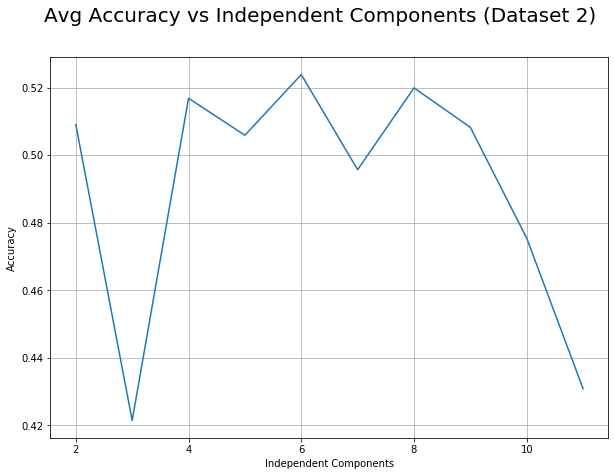

In [363]:
components = 2 + np.arange(10)
var = []
fin_acc = []
t = []
kurt=[]

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)

for component in components:
#     print("==============================")
#     print("Number of components: ", component)
    
    transformer = FastICA(n_components = component, whiten=True, random_state=random_seed)
    X_transformed = transformer.fit_transform(x)
    tmp = pd.DataFrame(X_transformed)
    tmp = tmp.kurt(axis=0)
    kurt.append(tmp.abs().mean())
    
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        X_transformed, y, test_size=0.2, random_state=random_seed)
    
    classifier = KMeans(n_clusters=2, max_iter=1000, random_state=random_seed)
    
    acc = []
    
    for train_index, test_index in kf.split(X_real_train):
        y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
        X_train = X_real_train[[train_index]]
        X_test = X_real_train[[test_index]]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc.append(metrics.accuracy_score(y_pred, y_test))
        i += 1
    
#     print("Average Accuracy: ", sum(acc)/len(acc))
    fin_acc.append(sum(acc)/len(acc))
        
plt.figure(figsize=(10, 7))
plt.suptitle("ICA Kurtosis (Dataset 2)", fontsize=20)
plt.xlabel("Independent Components")
plt.ylabel("Avg Kurtosis Across IC")
plt.plot(components, kurt, 'b-')
plt.savefig('WQKurtosis.png')
plt.grid()
plt.show()


plt.figure(figsize=(10, 7))
plt.suptitle('Avg Accuracy vs Independent Components (Dataset 2)', fontsize=20)
plt.xlabel('Independent Components')
plt.ylabel('Accuracy')
plt.plot(components, fin_acc)
plt.grid()
plt.show()

#### Reproducing

In [364]:
var = []
fin_acc = []
t = []

transformer = FastICA(n_components = 10, whiten=True, random_state=random_seed)
X_transformed = transformer.fit_transform(x)

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=0)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = KMeans(n_clusters=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.4230201244354248
Testing Accuracy:  0.609375


### EM

Number of components:  2
Shape:  (1599, 2)
Average Accuracy:  0.4707475490196078
Number of components:  3
Shape:  (1599, 3)
Average Accuracy:  0.4448345588235294
Number of components:  4
Shape:  (1599, 4)
Average Accuracy:  0.5427175245098039
Number of components:  5
Shape:  (1599, 5)
Average Accuracy:  0.5364950980392157
Number of components:  6
Shape:  (1599, 6)
Average Accuracy:  0.42860906862745096
Number of components:  7
Shape:  (1599, 7)
Average Accuracy:  0.40045649509803927
Number of components:  8
Shape:  (1599, 8)
Average Accuracy:  0.4737132352941177
Number of components:  9
Shape:  (1599, 9)
Average Accuracy:  0.4098376225490196
Number of components:  10
Shape:  (1599, 10)
Average Accuracy:  0.43609987745098044
Number of components:  11
Shape:  (1599, 11)
Average Accuracy:  0.48143688725490197


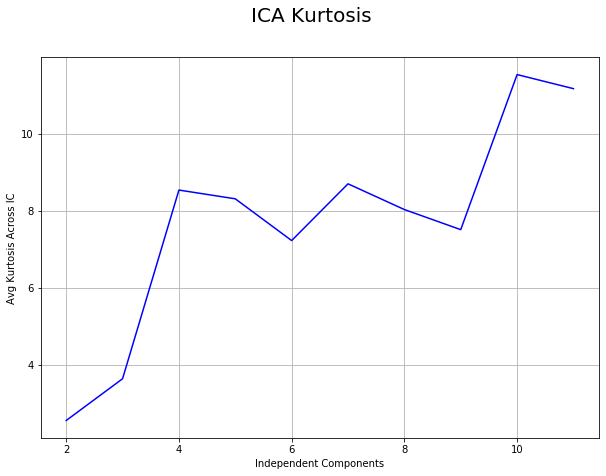

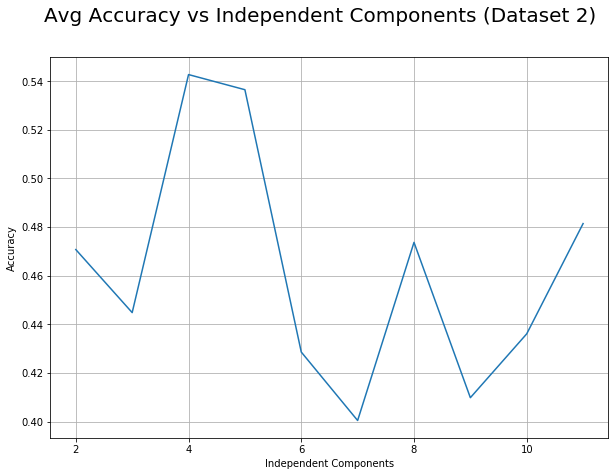

In [293]:
components = 2 + np.arange(10)
var = []
fin_acc = []
t = []
kurt=[]

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)

for component in components:
    print("==============================")
    print("Number of components: ", component)
    
    transformer = FastICA(n_components = component, random_state=random_seed)
    X_transformed = transformer.fit_transform(x)
    tmp = pd.DataFrame(X_transformed)
    tmp = tmp.kurt(axis=0)
    kurt.append(tmp.abs().mean())
    print("Shape: ", X_transformed.shape)
    
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        X_transformed, y, test_size=0.2, random_state=random_seed)
    
    classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)
    
    acc = []
    
    for train_index, test_index in kf.split(X_real_train):
        y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
        X_train = X_real_train[[train_index]]
        X_test = X_real_train[[test_index]]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc.append(metrics.accuracy_score(y_pred, y_test))
        i += 1
    
    print("Average Accuracy: ", sum(acc)/len(acc))
    fin_acc.append(sum(acc)/len(acc))
        
plt.figure(figsize=(10, 7))
plt.suptitle("ICA Kurtosis", fontsize=20)
plt.xlabel("Independent Components")
plt.ylabel("Avg Kurtosis Across IC")
plt.plot(components, kurt, 'b-')
plt.grid()
plt.show()


plt.figure(figsize=(10, 7))
plt.suptitle('Avg Accuracy vs Independent Components (Dataset 2)', fontsize=20)
plt.xlabel('Independent Components')
plt.ylabel('Accuracy')
plt.plot(components, fin_acc)
plt.grid()
plt.show()

#### Reproducing

In [365]:
var = []
fin_acc = []
t = []

transformer = FastICA(n_components = 10, whiten=True, random_state=random_seed)
X_transformed = transformer.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=0)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.19645214080810547
Testing Accuracy:  0.221875


### Neural Network

In [399]:
data['quality'] = data.quality.apply(lambda q: 0 if q <= 5 else 1)
y = data['quality']
x = data.drop('quality', axis=1)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(x, y, test_size=0.2, random_state=0)

Total Time Taken:  3.3625879287719727
Testing Accuracy:  1.0


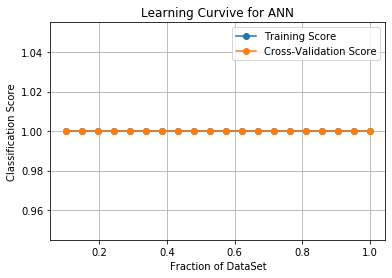

In [401]:
transformer = FastICA(n_components=10, whiten=True, random_state=random_seed)
X_transformed = transformer.fit_transform(x)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=random_seed)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")
plt.savefig('WQICANN.png')

# Randomized Projection

In [366]:
data['quality'] = data.quality.apply(lambda q: 0 if q <= 5 else 1)
y = data['quality']
x = data.drop('quality', axis=1)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(x, y, test_size=0.2, random_state=0)

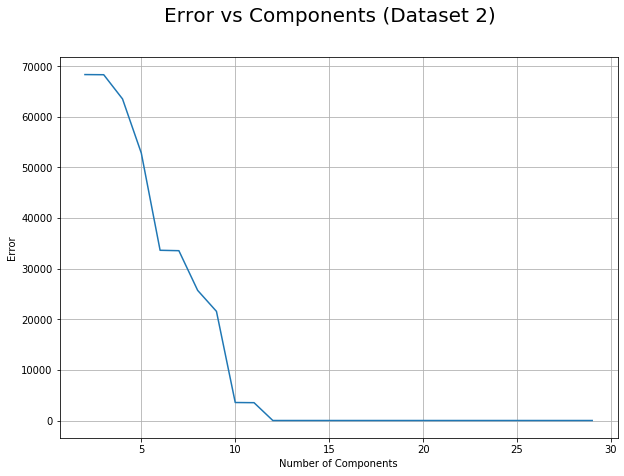

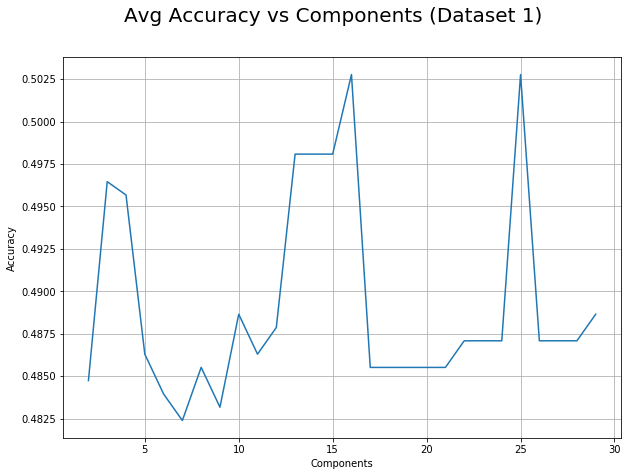

In [369]:
error = []
fin_acc = []
components = 2 + np.arange(28)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)

for component in components:
#     print("==============================")
#     print("Number of components: ", component)
    
    transformer = GaussianRandomProjection(n_components=component, random_state=random_seed)
    X_new = transformer.fit_transform(x)
    temp = np.linalg.pinv(transformer.components_.T)
    reconstructed = np.dot(X_new, temp)
    err = mean_squared_error(x, reconstructed)
    error.append(err)
    
    
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        X_new, y, test_size=0.2, random_state=random_seed)
    
    classifier = KMeans(n_clusters=2, max_iter=1000, random_state=random_seed)
    
    acc = []
    
    for train_index, test_index in kf.split(X_real_train):
        y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
        X_train = X_real_train[[train_index]]
        X_test = X_real_train[[test_index]]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        acc.append(metrics.accuracy_score(y_pred, y_test))
        i += 1
    
#     print("Average Accuracy: ", sum(acc)/len(acc))
    fin_acc.append(sum(acc)/len(acc))
        

plt.figure(figsize=(10, 7))
plt.suptitle('Error vs Components (Dataset 2)', fontsize=20)
plt.xlabel('Number of Components')
plt.ylabel('Error')
plt.plot(components, error)
plt.savefig('WQReconstruction.png')
plt.grid()
plt.show()
        
plt.figure(figsize=(10, 7))
plt.suptitle('Avg Accuracy vs Components (Dataset 1)', fontsize=20)
plt.xlabel('Components')
plt.ylabel('Accuracy')
plt.plot(components, fin_acc)
plt.grid()
plt.show()

### Reproducing

In [370]:
var = []
fin_acc = []
t = []

transformer = GaussianRandomProjection(n_components=6, random_state=random_seed)
X_new = transformer.fit_transform(x)

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_new, y, test_size=0.2, random_state=0)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = KMeans(n_clusters=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.267031192779541
Testing Accuracy:  0.49375


In [371]:
var = []
fin_acc = []
t = []

transformer = GaussianRandomProjection(n_components=6, random_state=random_seed)
X_new = transformer.fit_transform(x)

X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    X_new, y, test_size=0.2, random_state=0)

kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = GaussianMixture(n_components=2, max_iter=1000, random_state=random_seed)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train = X_real_train[[train_index]]
    X_test = X_real_train[[test_index]]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

Total Time Taken:  0.21880507469177246
Testing Accuracy:  0.165625


# Random Forest Classifier

In [374]:
data['quality'] = data.quality.apply(lambda q: 0 if q <= 5 else 1)
y = data['quality']
x = data.drop('quality', axis=1)
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [385]:
rfc = RandomForestClassifier(n_estimators=500, min_samples_leaf=round(
        len(x)*.01), random_state=random_seed)

new_x = rfc.fit(x, y).feature_importances_
new_x = pd.DataFrame(
        new_x, columns=['Feature Importance'], index=x.columns[0::])
new_x.sort_values(by=['Feature Importance'], inplace=True, ascending=False)

new_x['Cum Sum'] = new_x['Feature Importance'].cumsum()
new_x = new_x[new_x['Cum Sum'] <= 0.9]
best_columns = new_x.index.tolist()


In [403]:
rfc_x = x[best_columns]
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(rfc_x, y, test_size=0.2, random_state=0)
rfc_x.shape

(1599, 12)

# Treating Clusters as New Features

In [412]:
data = pd.read_csv('wineQualityReds.csv')
data = data.drop('Unnamed: 0', axis=1)
data['quality'] = data.quality.apply(lambda q: 0 if q <= 5 else 1)
y = data['quality']
x = data.drop('quality', axis=1)
x = StandardScaler().fit_transform(x)

In [413]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    x, y, test_size=0.2, random_state=random_seed)

classifier = KMeans(n_clusters=7, random_state=random_seed)
classifier.fit(x)
kmeans_labels = classifier.labels_
print("K Means: ", len(kmeans_labels))

classifier = GaussianMixture(n_components=2, random_state=random_seed)
classifier.fit(x)
em_labels = classifier.predict(x)
print("EM: ", len(em_labels))

K Means:  1599
EM:  1599


In [406]:
x_original = pd.DataFrame()
x_original['KMeans Labels'] = kmeans_labels
x_original['EM Labels'] = em_labels

print("Shape: ", x_original.shape)

Shape:  (1599, 2)


### Neural Network

Total Time Taken:  4.374572038650513
Testing Accuracy:  0.715625


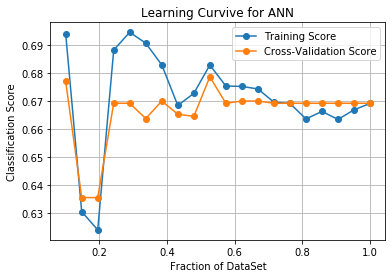

In [407]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    x_original, y, test_size=0.2, random_state=random_seed)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train, X_test = X_real_train.iloc[train_index], X_real_train.iloc[test_index]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")

In [408]:
data = pd.read_csv('wineQualityReds.csv')
data = data.drop('Unnamed: 0', axis=1)
data['quality'] = data.quality.apply(lambda q: 0 if q <= 5 else 1)
y = data['quality']
x = data.drop('quality', axis=1)
x = StandardScaler().fit_transform(x)

In [417]:
x_original = pd.DataFrame(x)
x_original['KMeans Labels'] = kmeans_labels
x_original['EM Labels'] = em_labels

print("Shape: ", x_original.shape)

Shape:  (1599, 13)


Total Time Taken:  21.668821811676025
Testing Accuracy:  0.790625


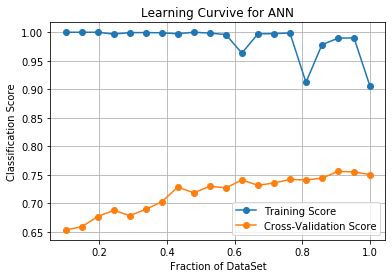

In [419]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    x_original, y, test_size=0.2, random_state=random_seed)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train, X_test = X_real_train.iloc[train_index], X_real_train.iloc[test_index]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")
plt.savefig('FinalWQ.png')

### PCA

In [420]:
data = pd.read_csv('wineQualityReds.csv')
data = data.drop('Unnamed: 0', axis=1)
data['quality'] = data.quality.apply(lambda q: 0 if q <= 5 else 1)
y = data['quality']
x = data.drop('quality', axis=1)
x = StandardScaler().fit_transform(x)

In [421]:
transformer_pca = PCA(n_components=8, random_state=random_seed)
x_pca = transformer_pca.fit_transform(x)

classifier = KMeans(n_clusters=7, random_state=random_seed)
classifier.fit(x_pca)
kmeans_labels = classifier.labels_
print("K Means: ", len(kmeans_labels))

transformer_pca = PCA(n_components=2, random_state=random_seed)
x_pca = transformer_pca.fit_transform(x)
classifier = GaussianMixture(n_components=2, random_state=random_seed)
classifier.fit(x)
em_labels = classifier.predict(x)
print("EM: ", len(em_labels))

K Means:  1599
EM:  1599


In [422]:
x_original = pd.DataFrame()
x_original['KMeans Labels'] = kmeans_labels
x_original['EM Labels'] = em_labels
print("Shape: ", x_original.shape)

Shape:  (1599, 2)


Total Time Taken:  4.716464281082153
Testing Accuracy:  0.73125


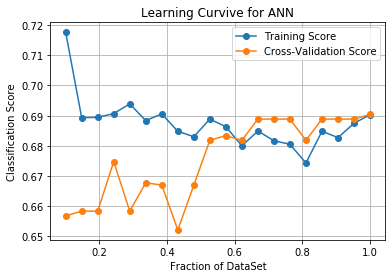

In [423]:
X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
    x_original, y, test_size=0.2, random_state=random_seed)


kf = KFold(n_splits=5, random_state=0, shuffle=True)
kf.get_n_splits(X_real_train)
KMeans_Score = []
KMeans_Classifier = []
i = 1
start_time = time.time()
classifier = MLPClassifier(random_state=random_seed, max_iter=5000)

for train_index, test_index in kf.split(X_real_train):
    y_train, y_test = y_real_train.iloc[train_index], y_real_train.iloc[test_index]
    X_train, X_test = X_real_train.iloc[train_index], X_real_train.iloc[test_index]
    

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = metrics.accuracy_score(y_pred, y_test)
    i += 1

end_time = time.time()
print("Total Time Taken: ", end_time - start_time)

## Testing Set
y_pred = classifier.predict(X_real_test)
accuracy = metrics.accuracy_score(y_pred, y_real_test)
print("Testing Accuracy: ", accuracy)

plot_learning_curve(classifier, X_real_train, y_real_train, title="Learning Curvive for ANN")